In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
import scipy


In [2]:
df = pd.read_excel('Nile.xlsx')

In [3]:
df.rename(columns={'Unnamed: 0':'Year'}, inplace=True)

# Figure 2.1 - Kalman Filter

In [4]:
# For initialization typically take a1=0 and P1=10´7
def kalman_filter(df, a_1, P_1, sigma_e, sigma_n):

    a_list = [a_1]
    P_list = [P_1]
    v_list = []
    F_list = []
    K_list = []

    for t in range(0,len(df)):
        # Note that in Python the indexes start at 0 so t==1 is t=2 in the book and so on...
        
        v_f = df['Nile'][t] - a_list[t]
        v_list.append(v_f)
   
        F_f = P_list[t] + sigma_e # Note that we want to access P1 but this is the 0 index in the P_list, so we call use 't-1'
        F_list.append(F_f)

        
        K_f = P_list[t] / F_list[t]
        K_list.append(K_f)

        # Updating the knowledge (filtering and prediction steps)

         # for the first observation (t=1), a2 is same as a1_given1 and P2 is P1_given1+sigma_n
        a_f = a_list[t] + K_list[t] * v_list[t]
        a_list.append(a_f)

        P_f = (K_list[t] * sigma_e) + sigma_n 
        P_list.append(P_f)

    return a_list, P_list, v_list, F_list, K_list

a_list, P_list, v_list, F_list, K_list = kalman_filter(df, 0, 10**7, 15099, 1469)


In [5]:
a_list, P_list, v_list, F_list, K_list = kalman_filter(df, 0, pow(10,7), 15099, 1469)

In [6]:
df['a_list'] = a_list[1:]
df['P_list'] = P_list[1:]
df['v_list'] = v_list 
df['F_list'] = F_list

/var/folders/4s/gjls3b511cn2zy51zn4m4scm0000gn/T/ipykernel_3752/1922158101.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=df.Year[1:], y=df['Nile'], palette='r', ax=axs[0,0])


Text(0.5, 1.0, 'iv) Variance of prediction erros')

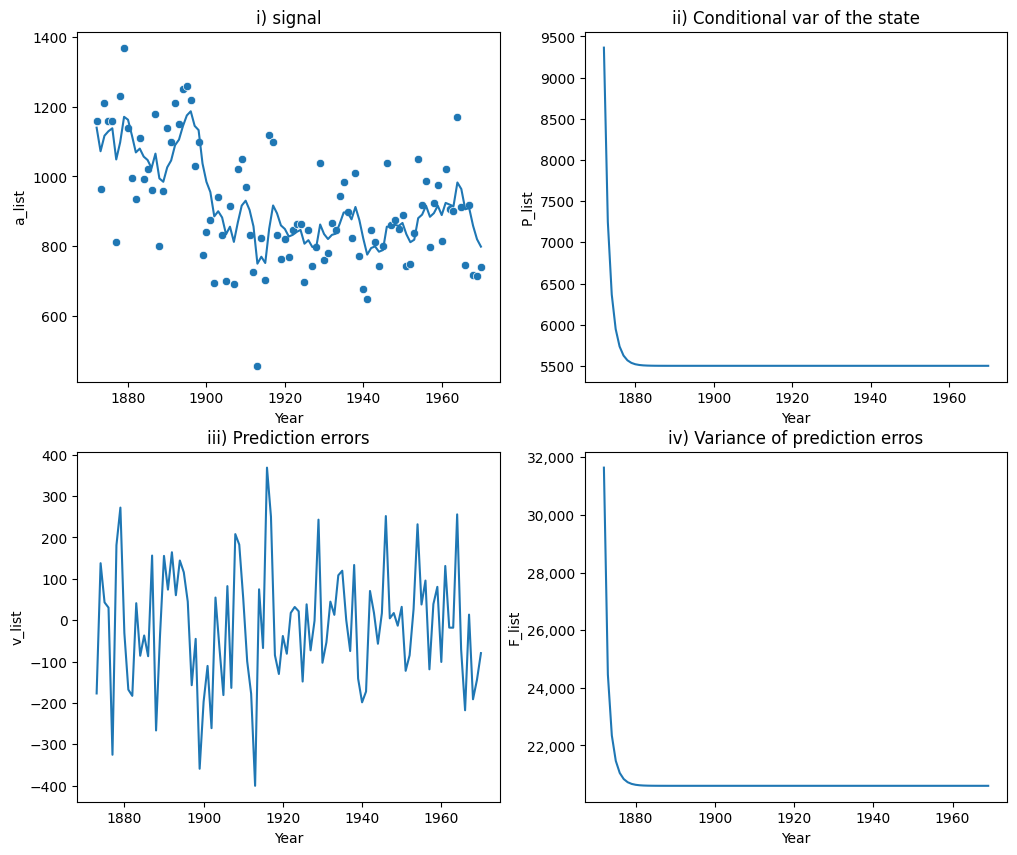

In [7]:
fig, axs = plt.subplots(2, 2, figsize = (12,10))

# Signal
sns.lineplot(x=df.Year[1:], y=df['a_list'], ax=axs[0,0])
sns.scatterplot(x=df.Year[1:], y=df['Nile'], palette='r', ax=axs[0,0])
axs[0, 0].set_title("i) signal")

#Conditional var of the state
sns.lineplot(x=df.Year[1:], y=df['P_list'][1:], ax=axs[0,1])
axs[0, 1].set_title("ii) Conditional var of the state")
    # display whole number in the y axis
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))


# Prediction errors
sns.lineplot(x=df.Year, y=df['v_list'][2:], ax=axs[1,0])
axs[1, 0].set_title("iii) Prediction errors")

# Variance of prediction errors
sns.lineplot(x=df.Year[1:], y=df['F_list'][:-1], ax=axs[1,1])

    # display whole number in the y axis
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
axs[1, 1].set_title("iv) Variance of prediction erros")

# Figure 2.2

In [8]:
#Initialization r=N=0

def smoother(df, a_list, P_list, v_list, F_list, K_list):

    r_list = [0]
    N_list = [0]
    V_list = []
    alpha_list = []
    t_reversed = list(reversed(range(0,len(df))))

    for t in reversed(range(0,len(df))):
        
      r = F_list[t]**-1 * v_list[t] + (1-K_list[t]) * r_list[t_reversed[t]]
      r_list.append(r)

      N = F_list[t]**-1 + (1-K_list[t])**2 * N_list[t_reversed[t]]
      N_list.append(N)

      alpha = a_list[t] + P_list[t] * r_list[t_reversed[t]+1]
      alpha_list.append(alpha)

      V = P_list[t] - P_list[t]**2 * N_list[t_reversed[t]+1]
      V_list.append(V)
    
    return r_list, N_list, alpha_list, V_list


    

In [9]:
r_list, N_list, alpha_list, V_list = smoother(df, a_list, P_list, v_list, F_list, K_list)

In [10]:

df['alpha_list'] = alpha_list[::-1]
df['V_list'] = V_list[::-1]
df['r_list'] = r_list[1:][::-1]
df['N_list'] = N_list[1:][::-1]

/var/folders/4s/gjls3b511cn2zy51zn4m4scm0000gn/T/ipykernel_3752/1782509158.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=df.Year[1:], y=df['Nile'], palette='r', ax=axs[0,0])


Text(0.5, 1.0, 'iv)  Smoothing cumulant variance')

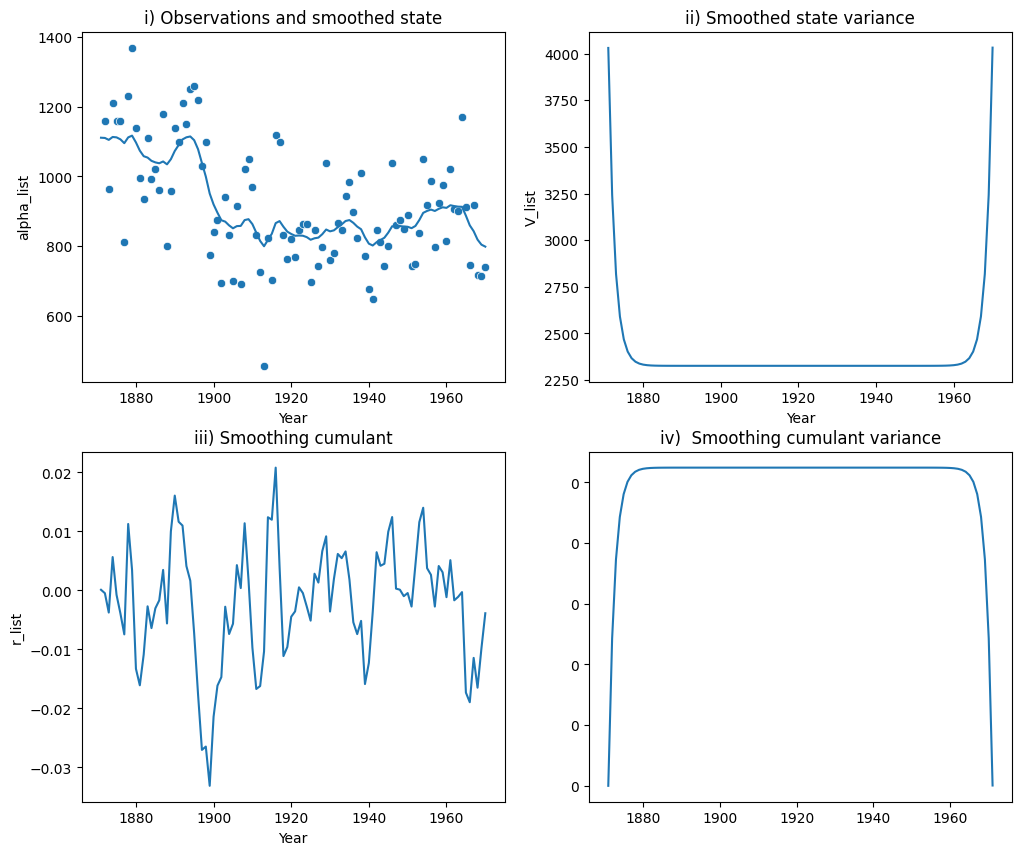

In [11]:
fig, axs = plt.subplots(2, 2, figsize = (12,10))

# Smoothed state and observations

sns.lineplot(x=df.Year, y=df['alpha_list'], ax=axs[0,0])
sns.scatterplot(x=df.Year[1:], y=df['Nile'], palette='r', ax=axs[0,0])
axs[0, 0].set_title("i) Observations and smoothed state")


# Smoothed state variance
sns.lineplot(x=df.Year, y=df['V_list'], ax=axs[0,1])
axs[0, 1].set_title("ii) Smoothed state variance")
    # display whole number in the y axis
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))


# Smoothing cumulant
sns.lineplot(x=df.Year, y=df['r_list'], ax=axs[1,0])
axs[1, 0].set_title("iii) Smoothing cumulant")


#  Smoothing cumulant variance
sns.lineplot(x=range(1871, 1972), y= N_list, ax=axs[1,1])

    # display whole number in the y axis
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
axs[1, 1].set_title("iv)  Smoothing cumulant variance")


# Figure 2.3

In [12]:
r_list = r_list[::-1]
N_list = N_list[::-1]


In [13]:
def disturbance_smoother(df, r_list, N_list, v_list, F_list, K_list, sigma_e, sigma_n):

    epsilon_hat_list = []
    var_epsilon_hat_list = []
    eta_hat_list = []
    var_eta_hat_list = []

    for t in range(0,len(df)):
        epsilon_hat = sigma_e * ((F_list[t]**-1 * v_list[t]) - (K_list[t] * r_list[t]))
        epsilon_hat_list.append(epsilon_hat)

        var_epsilon_hat = sigma_e - (sigma_e**2) * (1/F_list[t] + (K_list[t]**2) * N_list[t+1])
        var_epsilon_hat_list.append(var_epsilon_hat)

        eta_hat = sigma_n * r_list[t]
        eta_hat_list.append(eta_hat)

        var_eta_hat = sigma_n - sigma_n**2 * N_list[t+1]
        var_eta_hat_list.append(var_eta_hat)

    return epsilon_hat_list, var_epsilon_hat_list, eta_hat_list, var_eta_hat_list

In [14]:
epsilon_hat_list, var_epsilon_hat_list, eta_hat_list, var_eta_hat_list = disturbance_smoother(df, r_list, N_list, v_list, F_list, K_list, 15099, 1469)

In [15]:
sd_epsilon_hat_list = [num**0.5 for num in var_epsilon_hat_list]
sd_eta_hat_list = [num**0.5 for num in var_eta_hat_list]

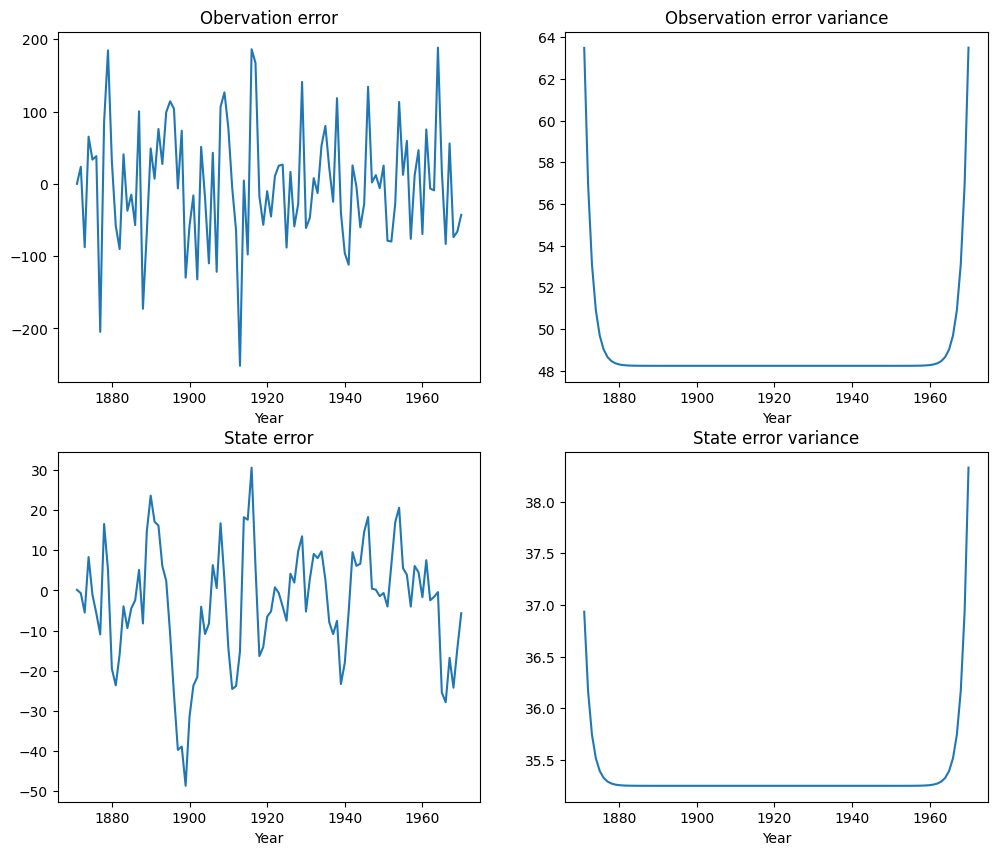

In [16]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Plot i
sns.lineplot(x=df.Year, y=epsilon_hat_list, ax=axs[0, 0])
axs[0, 0].set_title("Obervation error")

# Plot ii
sns.lineplot(x=df.Year, y=sd_epsilon_hat_list, ax=axs[0, 1])
axs[0, 1].set_title("Observation error variance")

# Plot iii
sns.lineplot(x=df.Year, y=eta_hat_list, ax=axs[1, 0])
axs[1, 0].set_title("State error")

# Plot iv
sns.lineplot(x=df.Year, y=sd_eta_hat_list, ax=axs[1, 1])
axs[1, 1].set_title("State error variance")
# Display the plot
plt.show()

# Figure 2.4

In [17]:
def simulation_one_draw(df, sigma_e, sigma_n, a1, P1):
    #Step 1: simulate epsilon and eta
    epsilon_plus = np.random.normal(0, sigma_e**0.5, 100)
    eta_plus = np.random.normal(0, sigma_n**0.5, 100)
    #Step 2: Set nitial state alpha_1 plus
    alpha_1 = df['Nile'][0]
    #Step 3: Obtain recursevely the states alpha_t plus and observations y_t plus
    alpha_plus_list = [alpha_1]
    y_plus_list = []
    for t in range(0,len(df)):
        alpha_plus = alpha_plus_list[t] + eta_plus[t]
        alpha_plus_list.append(alpha_plus)
        y_plus = alpha_plus_list[t] + epsilon_plus[t]
        y_plus_list.append(y_plus)    
    #Step 4: Apply kalman KFS to obtain one vector of alpha_hat_plus
    #Step 4.1: Prepare data
    df_sim = pd.DataFrame(data=y_plus_list, columns=['Nile'])
    #Step 4.2: Apply kalman filter
    a_list, P_list, v_list, F_list, K_list = kalman_filter(df_sim, a1, P1, sigma_e, sigma_n)
    #Step 4.3: Apply kalman smoother
    r_list, N_list, alpha_hat_plus_list, V_list = smoother(df_sim, a_list, P_list, v_list, F_list, K_list)
    #Switch the order of the relevant lists
    r_list = r_list[::-1]
    N_list = N_list[::-1]
    alpha_hat_plus_list = alpha_hat_plus_list[::-1]
    #Step 4.4: Apply disturbance smoother
    epsilon_hat_plus_list, var_epsilon_hat_list, eta_hat_plus_list, var_eta_hat_list = disturbance_smoother(df_sim, r_list, N_list, v_list, F_list, K_list, sigma_e, sigma_n)

    return alpha_hat_plus_list, alpha_plus_list, epsilon_hat_plus_list, eta_hat_plus_list, epsilon_plus, eta_plus

In [18]:
alpha_hat_plus_list, alpha_plus_list, epsilon_hat_plus_list, eta_hat_plus_list, epsilon_plus, eta_plus = simulation_one_draw(df, 15099, 1469, 0, 10**7)

In [19]:
#Step 5: calculate alpha_tilda
#switch order of alpha list
alpha_list = alpha_list[::-1]

alpha_tilda_list = []
for i in range(0, len(alpha_hat_plus_list)):
    alpha_tilda = alpha_list[i] + alpha_plus_list[i] - alpha_hat_plus_list[i]
    alpha_tilda_list.append(alpha_tilda)

#Step 6: calculate epsilon_tilda and eta_tilda
epsilon_tilda_list = []
eta_tilda_list = []
for i in range(0, len(epsilon_hat_plus_list)):
    epsilon_tilda = epsilon_plus[i] - epsilon_hat_plus_list[i] + epsilon_hat_list[i]
    epsilon_tilda_list.append(epsilon_tilda)
    eta_tilda = eta_plus[i] - eta_hat_plus_list[i] + eta_hat_list[i]
    eta_tilda_list.append(eta_tilda)



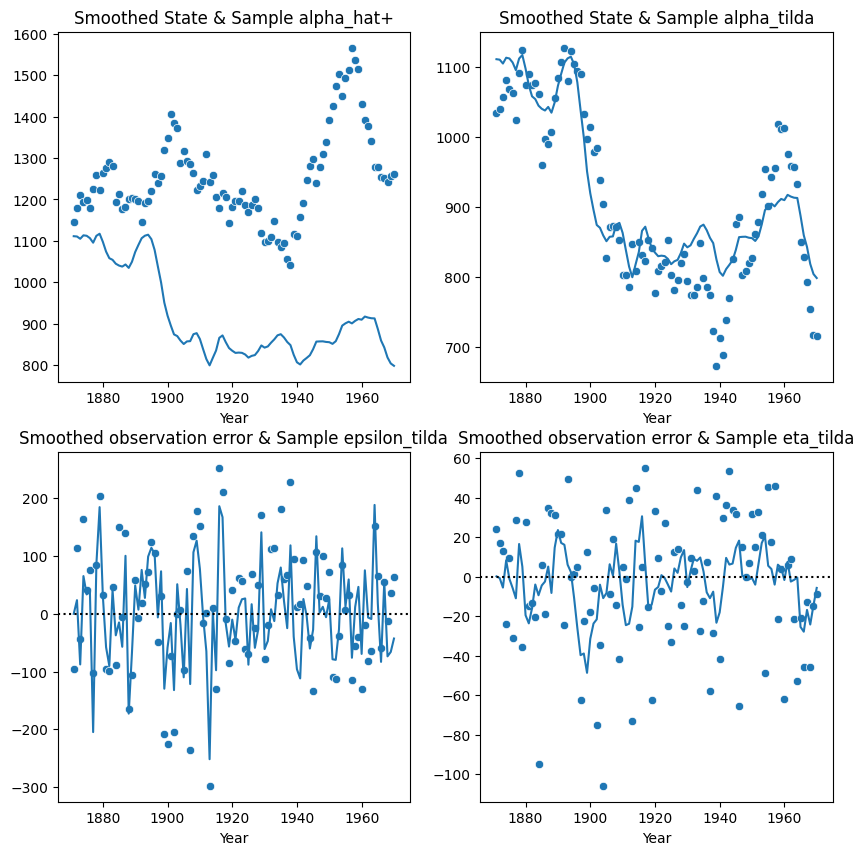

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot 1
sns.lineplot(x=df.Year, y=alpha_list, ax=axs[0, 0])
sns.scatterplot(x=df.Year, y=alpha_plus_list[1:], ax=axs[0, 0])
axs[0, 0].set_title("Smoothed State & Sample alpha_hat+")

# Plot 2
sns.lineplot(x=df.Year, y=alpha_list, ax=axs[0, 1])
sns.scatterplot(x=df.Year, y=alpha_tilda_list, ax=axs[0, 1])
axs[0, 1].set_title("Smoothed State & Sample alpha_tilda")

# Plot 3
sns.lineplot(x=df.Year, y=epsilon_hat_list, ax=axs[1, 0])
sns.scatterplot(x=df.Year, y=epsilon_tilda_list, ax=axs[1, 0])
axs[1, 0].axhline(y=0, color='k', linestyle=':')
axs[1, 0].set_title("Smoothed observation error & Sample epsilon_tilda") 

# Plot 4
sns.lineplot(x=df.Year, y=eta_hat_list, ax=axs[1, 1])
sns.scatterplot(x=df.Year, y=eta_tilda_list, ax=axs[1, 1])
axs[1, 1].axhline(y=0, color='k', linestyle=':')
axs[1, 1].set_title("Smoothed observation error & Sample eta_tilda")
# Display the plot
plt.show()




# Figure 2.7

In [31]:
# Calculate forecast errors

e_t = df['v_list'] / (df['F_list'].apply(np.sqrt))

In [32]:
df['e_t'] = e_t

/var/folders/4s/gjls3b511cn2zy51zn4m4scm0000gn/T/ipykernel_1218/2236367108.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['e_t'][:-1], hist=True, kde=True, ax=axs[0,1])


NameError: name 'sm' is not defined

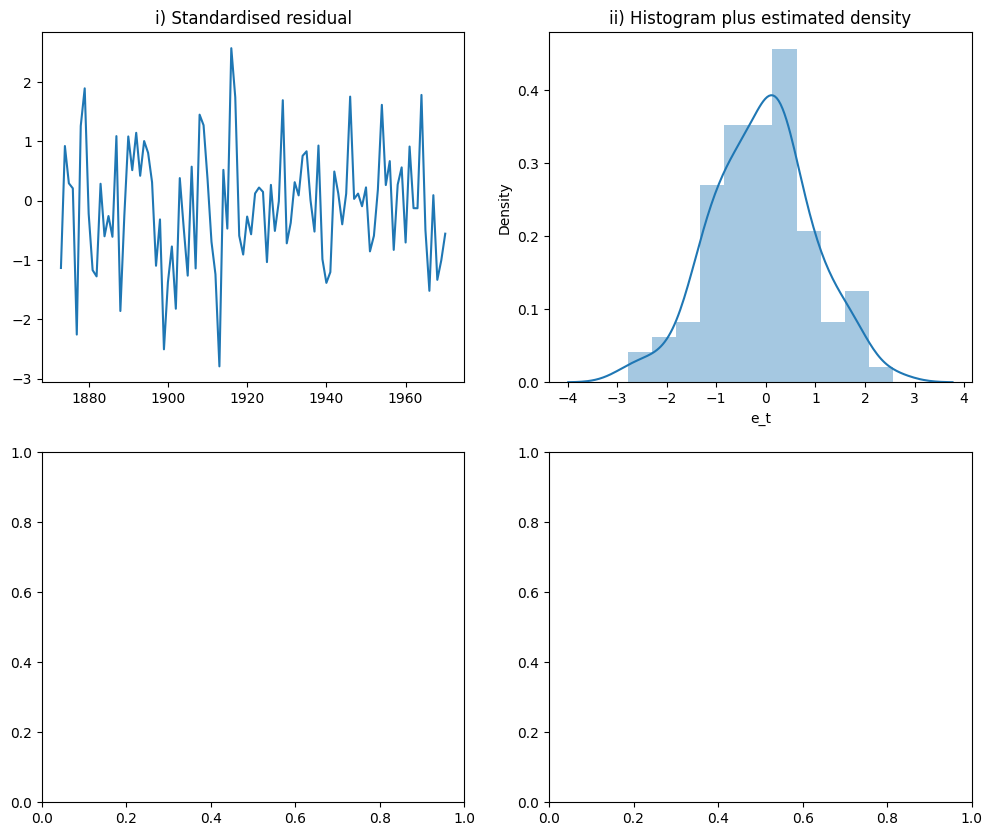

In [33]:
fig, axs = plt.subplots(2, 2, figsize = (12,10))

# Standardised residuals
axs[0, 0].plot(df['Year'][2:], df['e_t'][2:])
axs[0, 0].set_title("i) Standardised residual")

# Histogram plus estimated density
sns.distplot(df['e_t'][:-1], hist=True, kde=True, ax=axs[0,1])
axs[0, 1].set_title("ii) Histogram plus estimated density")

# Ordered residuals

sm.qqplot(df['e_t'][:-1], line="s", ax=axs[1,0])
axs[1, 0].set_title("iii) Ordered residuals")

# Correlogram
plt.acorr(df['e_t'][1:-1], maxlags=20)
plt.xlim([0,11])
plt.ylim([-0.3, 0.3])
axs[1, 1].set_title("iv) Correlogram")
#sm.graphics.tsa.plot_acf(df['e_t'][:-1], lags=10, ax=axs[1,1])

# Figure 2.8

2.12.2, page 39

In [225]:
u_t = df['e_t'] / np.var(df['e_t'])

In [48]:
print(theta_ini)

[15000  1500]


In [75]:
theta_ini = np.array([15099, 1469])


In [ ]:
def kalman_filter(df, a_1, P_1, sigma_e, sigma_n):

    a_list = [a_1]
    P_list = [P_1]
    v_list = []
    F_list = []
    K_list = []

    for t in range(0,len(df)):
        # Note that in Python the indexes start at 0 so t==1 is t=2 in the book and so on...
        
        v_f = df['Nile'][t] - a_list[t]
        v_list.append(v_f)
   
        F_f = P_list[t] + sigma_e # Note that we want to access P1 but this is the 0 index in the P_list, so we call use 't-1'
        F_list.append(F_f)

        
        K_f = P_list[t] / F_list[t]
        K_list.append(K_f)

        # Updating the knowledge (filtering and prediction steps)

         # for the first observation (t=1), a2 is same as a1_given1 and P2 is P1_given1+sigma_n
        a_f = a_list[t] + K_list[t] * v_list[t]
        a_list.append(a_f)

        P_f = (K_list[t] * sigma_e) + sigma_n 
        P_list.append(P_f)

    return a_list, P_list, v_list, F_list, K_list


In [78]:
def loglikelihood(df, theta):
    
    a_list = [0]
    P_list = [10**7]
    v_list = []
    F_list = []
    
   
    ll = 0
    ll_list = [ll]
    P = 10**7

    for t in range(1,len(df)):
        P = P + theta[1]

        v = df['Nile'][t] - a_list[t-1]
        v_list.append(v)
        F = P + theta[0]
        F_list.append(F)
        K = P / F_list[t-1]
        a = a_list[t-1] + K * v_list[t-1]
        a_list.append(a)
        P = P*(1-K)

        ll = ll- 0.5 * math.log(2* np.pi) - 0.5 *(math.log(F_list[t-1])+ (v_list[t-1]**2/F_list[t-1]))
        ll_list.append(ll)

    return ll



In [79]:
loglikelihood(df, theta_ini)

-635.6967067876698

In [80]:
results = scipy.optimize.minimize(loglikelihood, df, [15000, 1500], method='Nelder-Mead')

/var/folders/4s/gjls3b511cn2zy51zn4m4scm0000gn/T/ipykernel_3752/3063338497.py:1: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  results = scipy.optimize.minimize(loglikelihood, df, [15000, 1500], method='Nelder-Mead')


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [86]:


def loglikelihood(theta, df):
    # switch the order of the input arguments
    a_list = [0]
    P_list = [10**7]
    v_list = []
    F_list = []

    ll = 0
    ll_list = [ll]
    P = 10**7

    for t in range(1,len(df)):
        P = P + theta[1]

        v = df[t] - a_list[t-1]
        v_list.append(v)
        F = P + theta[0]
        F_list.append(F)
        K = P / F_list[t-1]
        a = a_list[t-1] + K * v_list[t-1]
        a_list.append(a)
        P = P*(1-K)

        ll = ll- 0.5 * math.log(2* np.pi) - 0.5 *(math.log(F_list[t-1])+ (v_list[t-1]**2/F_list[t-1]))
        ll_list.append(ll)

    return -ll




In [87]:
# call the minimize function with the correct input arguments order
results = scipy.optimize.minimize(loglikelihood, [15000, 1500], args=(df['Nile'],), method='Nelder-Mead')

In [83]:
print(results)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 635.6942111233221
             x: [ 1.525e+04  1.483e+03]
           nit: 54
          nfev: 112
 final_simplex: (array([[ 1.525e+04,  1.483e+03],
                       [ 1.525e+04,  1.483e+03],
                       [ 1.525e+04,  1.483e+03]]), array([ 6.357e+02,  6.357e+02,  6.357e+02]))


### Maximization

In [ ]:
## 4. Initial Parameter Values

omega_ini = x[-1]**2/50  # initial value for omega
alpha_ini = 0.02  # initial value for alpha
beta_ini = 0.96 # initial value for beta
lampda_ini = 5 # initial value for lampda

theta_ini = np.array([omega_ini, alpha_ini, beta_ini, lampda_ini])




## 5. Optimize Log Likelihood Criterion

#  optim input:
# (1) negative log likelihood function: llik_fun_GARCH() note the minus when calculating the mean
# (2) initial parameter: theta_ini
# (3) parameter space bounds: lb & ub
# (4) optimization setup: control
#  Note: a number of parameter restriction are left empty with []

#  optim output:
# (1) parameter estimates: par
# (2) negative mean log likelihood value at theta_hat: value
# (3) exit flag indicating (no) convergence: convergence


results = scipy.optimize.minimize(llik_fun_GARCH, theta_ini, args=(x_KO),
                                  method='Nelder-Mead', bounds=( (-10,  10), # Parameter Space Bounds
                                                              (-10, 10),
                                                              (-10, 10),
                                                                (-10, 10),
                                                                (-10, 10)
                                                            
                                                            )) #restrictions in parameter space




## 7. Print Output

print('parameter estimates:')
print(results.x)

print('log likelihood value:')
print(results.fun)

print('exit flag:')
print(results.success)
#results$success #if exitflag=0: convergence ok
         #if exitflag>0: convergence failed
         # see also results$message for additional information returned by the optimizer
        